In [1]:
%matplotlib widget

import numpy as np
import numba as nb
from matplotlib import pyplot as plt

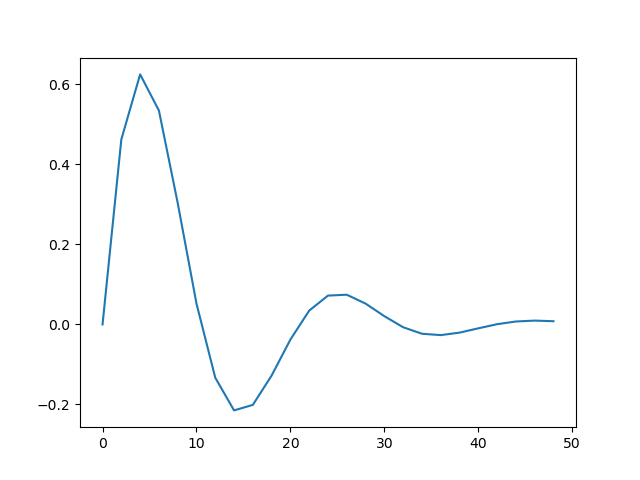

Mean rate: 22.7782319746802 Spikes/sec: 22.37


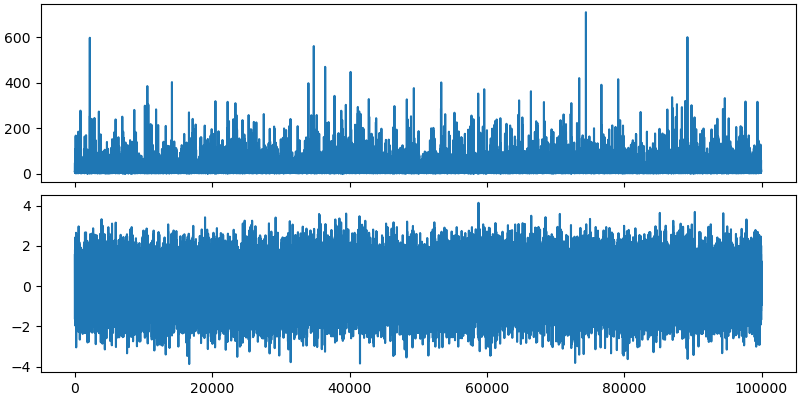

In [2]:
dt = 2 # 2ms
T = 100000
FT = 50
t = np.arange(0, T, dt)
ft = np.arange(0, FT, dt)
NT = len(t)
NFT = len(ft)

s = np.random.normal(0, 1, NT)

ftau = 10
fw = 0.3
filter = np.exp(-ft/ftau)*np.sin(fw*ft)

fig = plt.figure()
plt.plot(ft, filter)
plt.show()


r_max = 2000
theta = 5
delta = 1

drive = np.convolve(s, filter, mode='valid')
rate = r_max / (1 + np.exp((theta-drive)/delta))
rt = t[:len(rate)]
NRT = len(rt)

spikes = np.random.rand(len(rate)) < rate*dt/1000
spike_times = rt[spikes]
spike_index = np.where(spikes)[0]

print("Mean rate:", np.mean(rate), "Spikes/sec:", len(spike_times)/T*1000)

fig, ax = plt.subplots(2, 1, figsize=(8, 4), layout='constrained', sharex=True)
ax[0].plot(rt, rate)
# for st in spike_times:
#     ax[0].axvline(x=st, color='k', linestyle='-', linewidth=0.5)
ax[1].plot(t, s)
plt.show()

In [3]:
@nb.njit(parallel=True)
def get_sta(signal, spikes, sta, NFT):
    for i in nb.prange(len(spikes)):
        if spikes[i]-NFT+1 >= 0 and spikes[i]+NFT+1 < len(signal):
            sta[i] += signal[spikes[i]-NFT+1:spikes[i]+NFT+1]

In [4]:
# get STA
sta_array = np.zeros((len(spike_times), NFT*2))
get_sta(s, spike_index, sta_array, NFT)
sta = np.mean(sta_array, axis=0)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


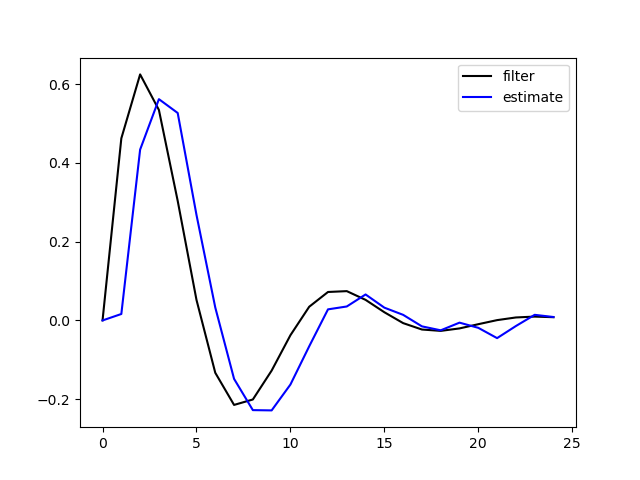

In [5]:
fig = plt.figure()
plt.plot(filter, c='k', label="filter")
plt.plot(sta[::-1][:len(filter)], c='b', label="estimate")
plt.legend()
plt.show()


In [6]:
theta = 15
delta = 2
quadratic_rate = r_max / (1 + np.exp((theta-drive**2)/delta))
rt = t[:len(rate)]
NRT = len(rt)

quad_spikes = np.random.rand(len(quadratic_rate)) < quadratic_rate*dt/1000
quad_spike_times = rt[quad_spikes]
quad_spike_index = np.where(quad_spikes)[0]

# get STA
quad_sta_array = np.zeros((len(quad_spike_index), NFT*2))
get_sta(s, quad_spike_index, quad_sta_array, NFT)
quad_sta = np.mean(quad_sta_array, axis=0)
quad_stc = np.cov(quad_sta_array.T)

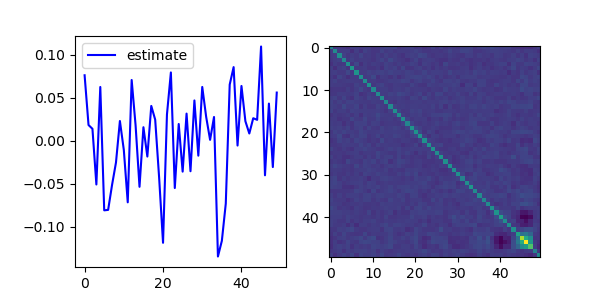

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].plot(quad_sta, c='b', label="estimate")
ax[0].legend()
ax[1].imshow(quad_stc)
plt.show()


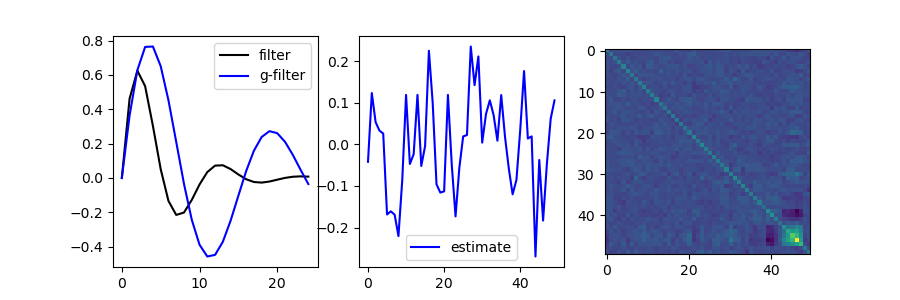

In [11]:
# 2-D Filter Case
theta = 15
delta = 2

gtau = 30
gw = 0.2
gfilter = np.exp(-ft/gtau)*np.sin(gw*ft)
gdrive = np.convolve(s, gfilter, mode='valid')

twod_quad_rate = r_max / (1 + np.exp((theta-drive**2)/delta)) / (1 + np.exp((theta-gdrive**2)/delta))

rt = t[:len(rate)]
NRT = len(rt)

twod_quad_spikes = np.random.rand(len(twod_quad_rate)) < twod_quad_rate*dt/1000
twod_quad_spike_times = rt[twod_quad_spikes]
twod_quad_spike_index = np.where(twod_quad_spikes)[0]

# get STA
twod_quad_sta_array = np.zeros((len(twod_quad_spike_index), NFT*2))
get_sta(s, twod_quad_spike_index, twod_quad_sta_array, NFT)
twod_quad_sta = np.mean(twod_quad_sta_array, axis=0)
twod_quad_stc = np.cov(twod_quad_sta_array.T)

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[0].plot(filter, c='k', label="filter")
ax[0].plot(gfilter, c='b', label="g-filter")
ax[0].legend()
ax[1].plot(twod_quad_sta, c='b', label="estimate")
ax[1].legend()
ax[2].imshow(twod_quad_stc)
plt.show()

In [17]:
print(np.min(twod_quad_rate), np.max(twod_quad_rate), np.min(quadratic_rate), np.max(quadratic_rate))

0.0006111335613407683 1393.768230559382 1.1055572751244105 1956.2501497305673


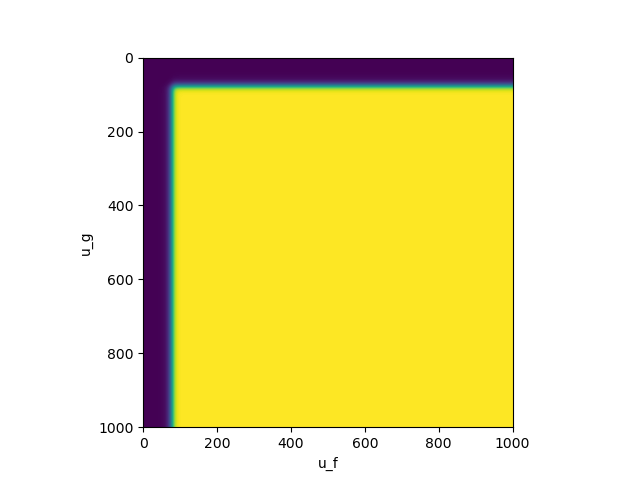

In [25]:
x, y = np.meshgrid(np.linspace(0, 50, 1001), np.linspace(0, 50, 1001))
z = r_max / (1 + np.exp((theta-x**2)/delta)) / (1 + np.exp((theta-y**2)/delta))

fig = plt.figure()
plt.imshow(z)
plt.xlabel("u_f")
plt.ylabel("u_g")
plt.show()